<div style="background-color: #FFF8C6; border:1px solid #000; margin-left: 2px; margin-right: 2px; padding-

bottom: 2px; padding-left: 2px; padding-right: 1px; padding-top: 10px;">
<center><b><font size="6">ANLT-232 HW 2 : Analysis of Flight Trends </font></b></center>
</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import seaborn as sns
from airplane_functions import import_clean_data, plotfunction, geo_graph
import statsmodels.api as sm

# Set dataframe max row display
pd.set_option('display.max_row', 200)

# set graph background color
sns.set_style("darkgrid", {'axes.facecolor': '.6'})

import warnings
warnings.simplefilter("ignore")

%matplotlib inline

## Data
The [data](http://stat-computing.org/dataexpo/2009/the-data.html) used for this analysis was originally published by the Bureau of Transportation Statistics and contains flight data from 1987 to 2008. However, only data from 2008 will be used. This is because of the scale of data collected throughout the period of time is very large and would be difficult to work with, so using the most recent year of data is the most reasonable option. The information contained in the data includes when a flight occurred, its departure location and destination, and information on total air time, including delays, among many other variables. In total, the 2008 data recorded over 7 million observations and 29 variables, and also provides conversions for specific codes used such as airport and airline codes. The site provides a [detailed explanation of the data](https://www.transtats.bts.gov/Fields.asp?Table_ID=236), including the variables used and relevant formatting rules.

As is, the data is separated into three different csv files. There are two individual files that translates the airplane and airline codes, and a larger file that records all of the flights and their statistics. Since the airplane/airport codes could be relevant to the analysis, a function was created to merge the different files together and do some light data cleaning, including dropping some columns deemed to be of no use for the purposes of the analysis.

In [2]:
# df = import_clean_data("2008.csv", "airports.csv", "carriers.csv")
# df.to_csv("data/clean.csv", index=False)

The above code is how the dataset was merged with the **import_clean_data** function created in the separate python file included in the first block of code. Since the data contained a large amount of observations, this merging step takes a while to finish, so the cleaned and merged data was instead saved to its own file in order to save on processing time for future iterations of this report.

In [3]:
df = pd.read_csv("data/clean.csv")

## Flight Cancellations

To start off the analysis, we will first observe the canceled flights and try to see any trends within the data in terms of when or why a flight might be cancelled. First, we can set up some variables to be used to accomplish this:

In [28]:
# list of months, weeks and cancellation types to use when plotting
m = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
w = ['Mon', 'Tues', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
c = ['Carrier', 'Weather', 'National Air System', 'Security']

Since it will be much more effecient to talk about the data as percentages rather than integers, it will be important to first know how many flights were scheduled per month in 2008. 


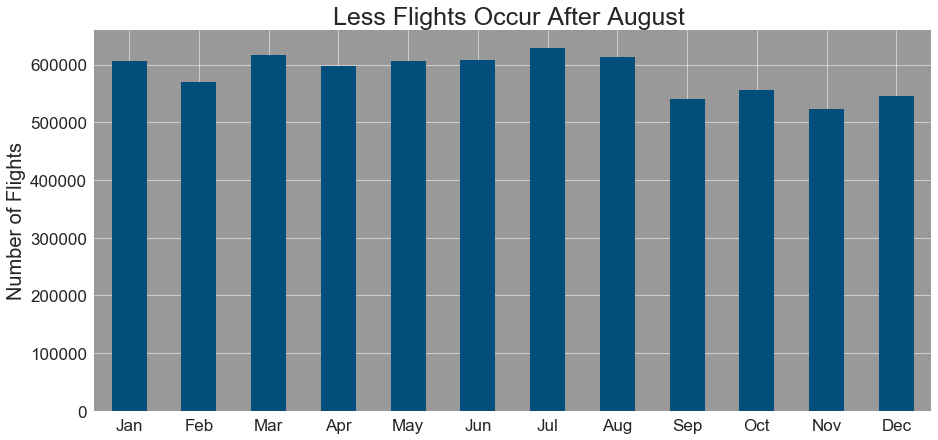

In [29]:
num_flights = df.Cancelled.groupby(df.Month).count()
plotfunction(num_flights, title = "Less Flights Occur After August ",
                          y_label = "Number of Flights",x_labels = m)

Breaking down the flights by day of the week will also be useful for the analysis.

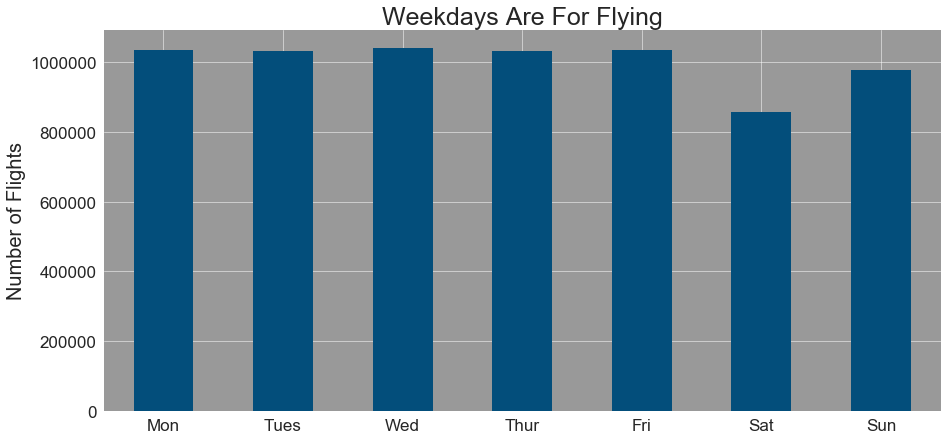

In [30]:
cancelled_dayofweek = df.Cancelled.groupby(df.DayOfWeek).count()
plotfunction(cancelled_dayofweek, y_label='Number of Flights', x_labels=w,
             title='Weekdays Are For Flying'); plt.show()

The weekdays are mostly uniform, but weekends saw less flight activity in 2008.

<hr>

Let's first look at the percentages of canceled flights by month to see if there are any noticeable times of the year when a flight could be more likely to be canceled. This could be important information for trip planning.

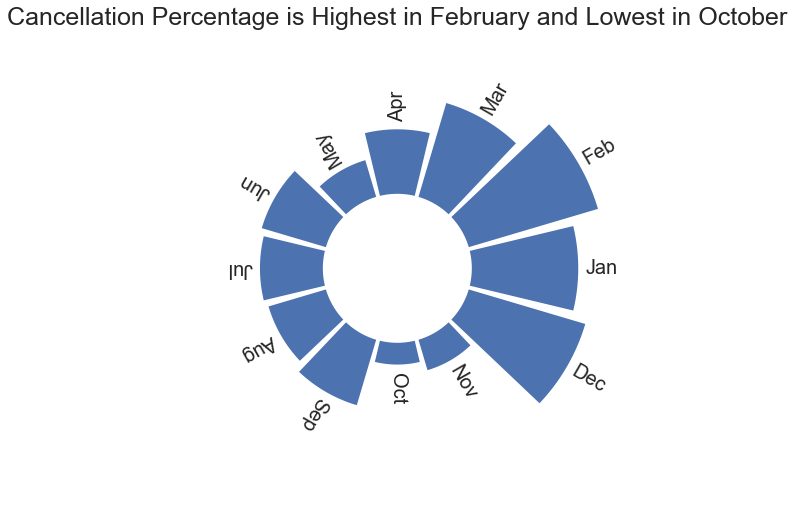

In [31]:
percent_cancelled_month = df.Cancelled.groupby(df.Month).mean()*100
iN = percent_cancelled_month.size
arrCnts = percent_cancelled_month

theta=np.arange(0,2*np.pi,2*np.pi/iN)
width = (2*np.pi)/iN *0.9
bottom = 2

fig = plt.figure(figsize=(8, 8))
ax = fig.add_axes([0.1, 0.1, 0.75, 0.75], polar=True)
bars = ax.bar(theta, arrCnts, width=width, bottom=bottom)
ax.set_xticks(theta)
ax.axis('off')
rotations = np.rad2deg(theta)
for x, bar, rotation, label in zip(theta, bars, rotations, m):
    lab = ax.text(x, bottom+bar.get_height()+.2, label,fontsize=20,
             ha='left', va='center', rotation=rotation, rotation_mode="anchor")
ax.set_title("Cancellation Percentage is Highest in February and Lowest in October", fontsize=25)
plt.show()

The graph reveals some noticeable differences in the amount of flights cancelled throughout the year. The graph shows that most cancellation happened in **February**. However, this increase in cancellations can be more generalised as a trend seen across the winter months (December-February). Immediately, a hypothesis that might give some explanation to this trend would be adverse weather conditions seen in colder months. For example, a snow storm could cause problems on airways as well as problems with visibility in the air, which could cause flights to be canceled until the conditions improve. This hypothesis will be revisited later, but for now let's just focus on time. 2008 saw an average of 1.9% of flights be cancelled per month; a little over 130 thousand flights per month on average. This information is helpful, but breaking it down on a day-to-day basis could be even more useful. Let's see if the days of the week can reveal any trend in flight cancellations

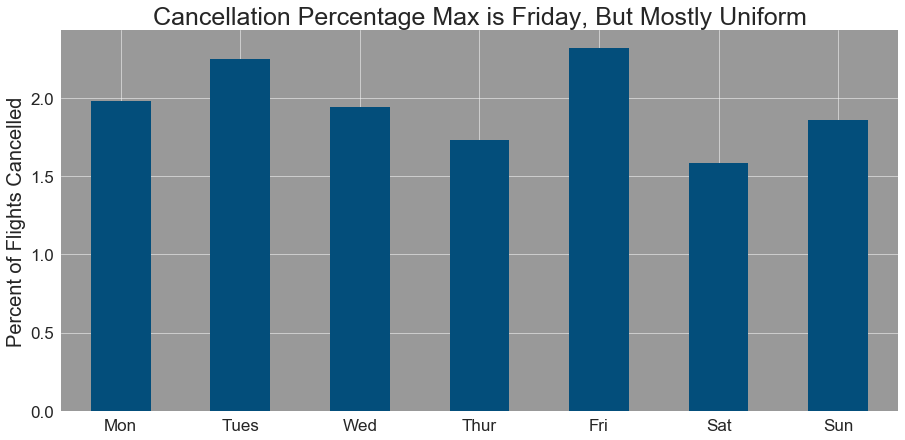

In [32]:
percent_cancelled_dayofweek = df.Cancelled.groupby(df.DayOfWeek).mean()*100
plotfunction(percent_cancelled_dayofweek, y_label='Percent of Flights Cancelled', x_labels=w,
             title='Cancellation Percentage Max is Friday, But Mostly Uniform'); plt.show()

The graph doesn't reveal any stark differences in flight cancellations between the days of the week. At least for 2008, **Friday** saw the most cancellation at about 2.7% of total flights scheduled on Fridays being cancelled. Considering how many flights are scheduled throughout the year, and how this number is only increasing as time goes on, it would be interesting to look at data for more recent years to see if cancellation trends have improved, or if the trend worsens as more flights are introduced into the mix.

Let's see what combining the previous two graphs tells us. That is, observing the daily trends of each month of 2008.

In [33]:
percent_cancelled_month_dayofweek = df.Cancelled.groupby([df.Month, df.DayOfWeek]).mean()*100
percent_cancelled_month_dayofweek = percent_cancelled_month_dayofweek.unstack()
percent_cancelled_month_dayofweek.index = m
percent_cancelled_month_dayofweek.columns = w

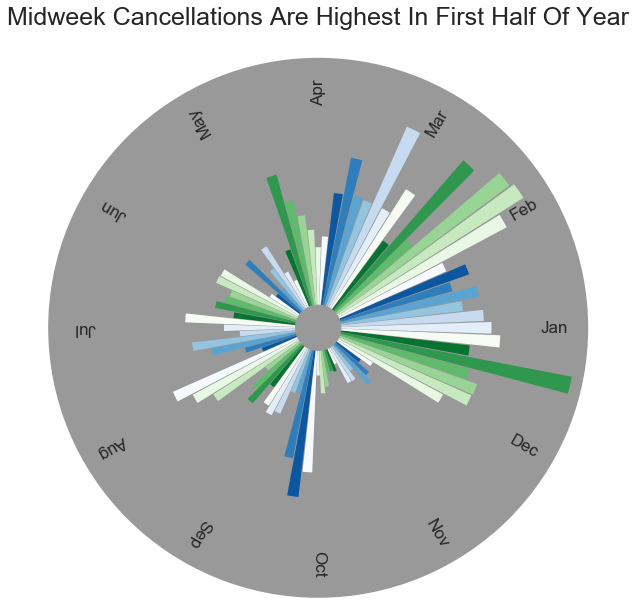

In [34]:
arrCnts = percent_cancelled_month_dayofweek
iN = arrCnts.size

a = plt.cm.Blues
c_ = plt.cm.Greens
colors=[[a(0.1), a(0.25), a(0.4), a(0.55), a(0.7), a(0.85), a(1)],
        [c_(0.1), c_(0.25), c_(0.4), c_(0.55), c_(0.7), c_(0.85), c_(1)],
        [a(0.1), a(0.25), a(0.4), a(0.55), a(0.7), a(0.85), a(1)],
        [c_(0.1), c_(0.25), c_(0.4), c_(0.55), c_(0.7), c_(0.85), c_(1)],
        [a(0.1), a(0.25), a(0.4), a(0.55), a(0.7), a(0.85), a(1)],
        [c_(0.1), c_(0.25), c_(0.4), c_(0.55), c_(0.7), c_(0.85), c_(1)],
        [a(0.1), a(0.25), a(0.4), a(0.55), a(0.7), a(0.85), a(1)],
        [c_(0.1), c_(0.25), c_(0.4), c_(0.55), c_(0.7), c_(0.85), c_(1)],
        [a(0.1), a(0.25), a(0.4), a(0.55), a(0.7), a(0.85), a(1)],
        [c_(0.1), c_(0.25), c_(0.4), c_(0.55), c_(0.7), c_(0.85), c_(1)],
        [a(0.1), a(0.25), a(0.4), a(0.55), a(0.7), a(0.85), a(1)],
        [c_(0.1), c_(0.25), c_(0.4), c_(0.55), c_(0.7), c_(0.85), c_(1)]]

theta=np.arange(0,2*np.pi,2*np.pi/iN)
theta = np.split(theta,12)

width = (2*np.pi)/iN *0.9
bottom = .5

fig = plt.figure(figsize=(10, 10))
ax = fig.add_axes([0.1, 0.1, 0.75, 0.75], polar=True)
for (month, days_week), t, a, ca in zip(arrCnts.iterrows(),theta, m, colors):
    bars = ax.bar(t, days_week, width=width, bottom=bottom, color=ca, label=a)
    ax.set_xticks(t)
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])

theta_months = np.arange(0,2*np.pi,2*np.pi/12)
rotations = np.rad2deg(theta_months)
for x, rotation, label in zip(theta_months, rotations, m*12):
        lab = ax.text(x, bottom+4.3, label, fontsize=17, ha='left',
                      va='center', rotation=rotation, rotation_mode="anchor")

ax.set_title("Midweek Cancellations Are Highest In First Half Of Year", fontsize=25)
plt.show()

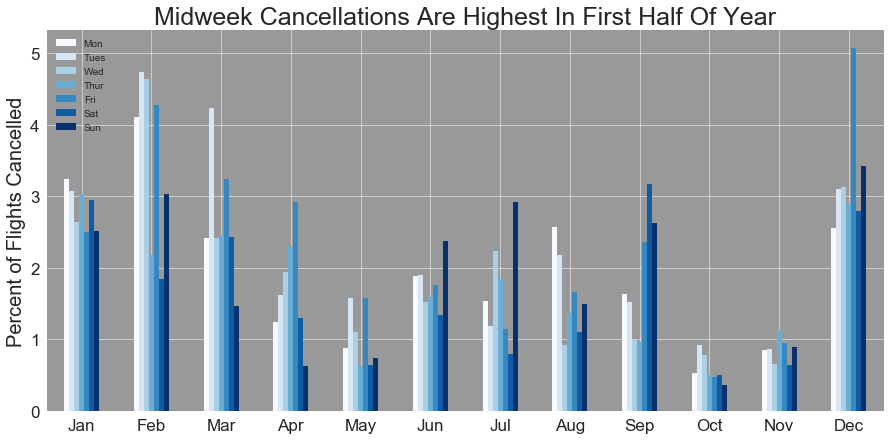

In [35]:
plotfunction(percent_cancelled_month_dayofweek, y_label='Percent of Flights Cancelled', x_labels=m,
    title='Midweek Cancellations Are Highest In First Half Of Year', simple=False); plt.show()

<hr>

Now that we know more information about how many flights were canceled in 2008, we can delve into *why* these flights were canceled. The data provides a variable called **CancellationCode**, which gives the reason that a flight was cancel, given as a code that is translated in another file which was merged earlier in the process. Let's observe those:

In [36]:
cancellation_type = df.Cancelled.groupby(df.CancellationCode).count()
cancellation_type = (cancellation_type / cancellation_type.sum())*100

can_type_month = df.Cancelled.groupby([df.CancellationCode, df.Month]).count().unstack()
can_type_month = ((can_type_month / can_type_month.sum())*100).T
can_type_month.columns = c

c_df = df.Cancelled.groupby([df.CancellationCode, df.Month, df.DayOfWeek]).count()
c_df = c_df.unstack()
c_df = (c_df / c_df.sum().sum())*100  # this makes it into percent
c_df.columns = w
# A = carrier, B = weather, C = NAS 'National Air System', D = security
carrier, weather, nas, security = c_df.loc['A'], c_df.loc['B'], c_df.loc['C'], c_df.loc['D']
carrier.index, weather.index, nas.index, security.index = m, m, m, ['Feb','Mar','May','Sep','Nov']

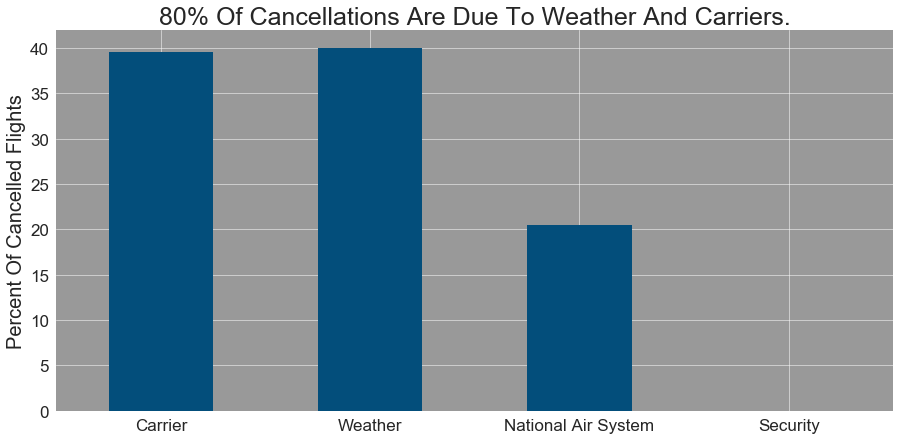

In [37]:
plotfunction(cancellation_type, y_label='Percent Of Cancelled Flights', x_labels=c,
             title='80% Of Cancellations Are Due To Weather And Carriers.'); plt.show()

The graph shows that a majority of cancellations were due to weather and carrier reasons, while virtually none were cancelled for security reasons. This can help support the hypothesis made earlier about how cancellations in winter months could be due in large part to weather complications, but as of right now this cannot be validated just knowing *why* flights were canceled. Combining *why* and *when* will further help to drive any validations of this hypothesis, and could possibly help garner new hypotheses to discuss.

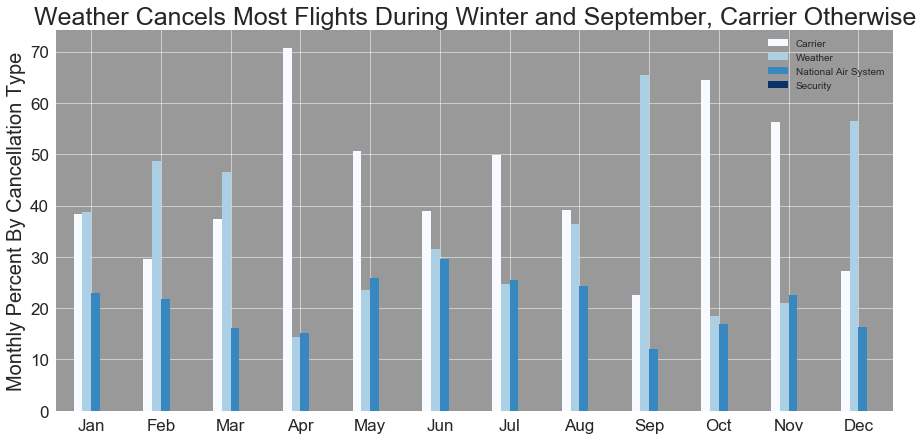

In [38]:
plotfunction(can_type_month, y_label='Monthly Percent By Cancellation Type', x_labels=m,
        title='Weather Cancels Most Flights During Winter and September, Carrier Otherwise',
             simple=False); plt.show()

Indeed, we can see that flights cancelled in winter months (December-February) were cancelled mostly because of weather reasons. There is also an interesting spike in weather-related cancellations in September, which looks to be an outlier compared to the months around it. [This article](https://www.ncdc.noaa.gov/sotc/national/200809) shows that September 2008 was the 38th wettest September recorded since 1895, due to multiple tropical storms that occurred over the month throughout the US. This can help provide some reasoning for the spike seen what appears to be randomly in September. For months that wouldn't normally be expected to have bad weather (April-November), the majority of cancellations were instead due to carrier reasons, though it is unclear as to what exactly this reason entails.

Let's get a better breakdown of each cancellation reason:

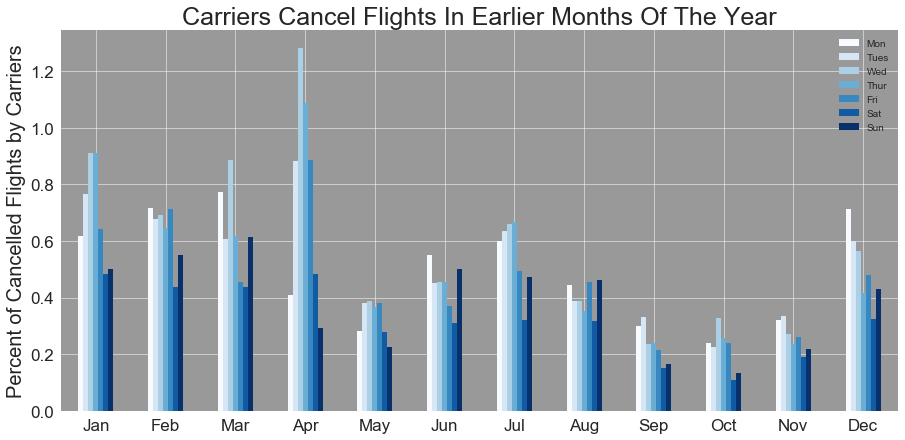

In [39]:
plotfunction(carrier, y_label='Percent of Cancelled Flights by Carriers', x_labels=m,
        title='Carriers Cancel Flights In Earlier Months Of The Year', simple=False); plt.show()

Again, while there isn't certainty as to *why* the airlines cancel flights (there are probably many reasons), it appears to happen more often in the earlier months of the year. Without knowing more specifically the reason for cancellation from the airlines, it is difficult to attach any hypothesis that could explain this trend.

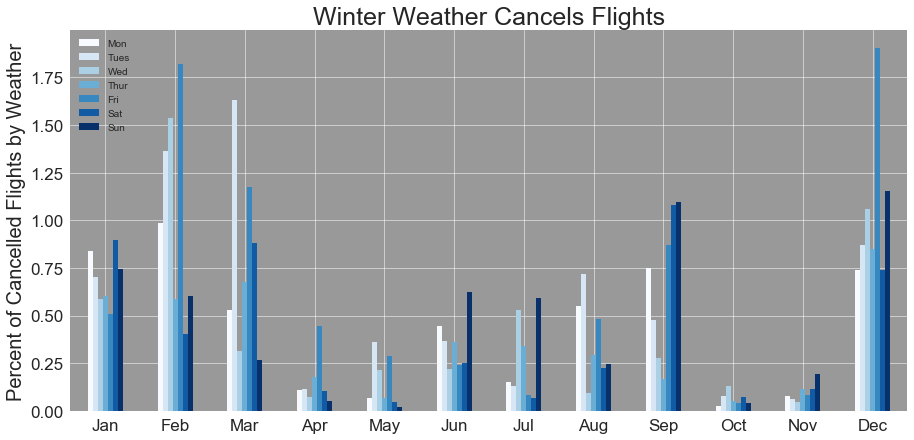

In [40]:
plotfunction(weather, y_label='Percent of Cancelled Flights by Weather', x_labels=m,
        title='Winter Weather Cancels Flights', simple=False); plt.show()

As this graph shows, there doesn't seem to be a correlation between the days of the week and when flights are cancelled due to weather conditions. Though, this lack of correlation may already be intuitive.

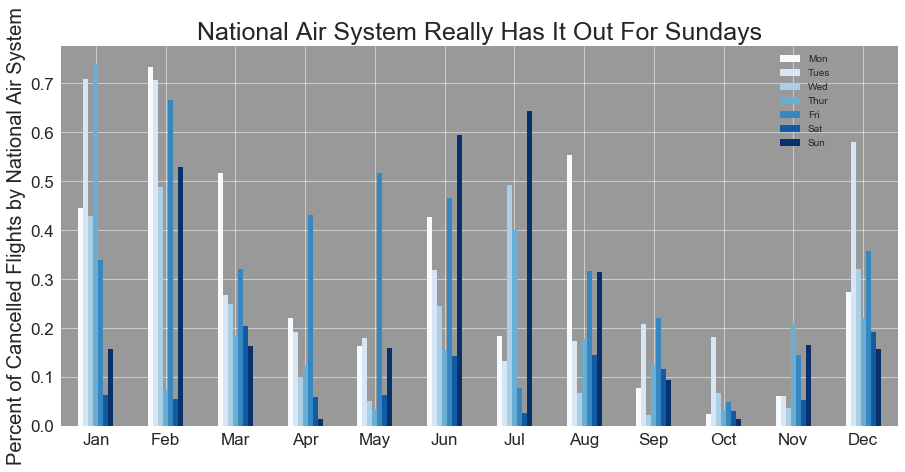

In [41]:
plotfunction(nas, y_label='Percent of Cancelled Flights by National Air System', x_labels=m,
title='National Air System Really Has It Out For Sundays', simple=False, l=(0.93, 1)); plt.show()

According to the Bureau of Transportation Statistics, delays and cancellations attributable to the National Aviation (Air) System refer to a broad set of conditions, such as non-extreme weather conditions, airport operations, heavy traffic volume, and air traffic control. There is therefore some correlation between the weather cancellation code and this one, but the NAS also takes many other factors into account when deciding to cancel flights. For the most part, however, it sounds like the reasoning behind cancelling flights for the NAS is because of over-congestions, whether in air or at the airport. Observing September-October, these months saw a lot less total flights than other months (via the chart at the very top of the report), which could help explain these flight cancellations.

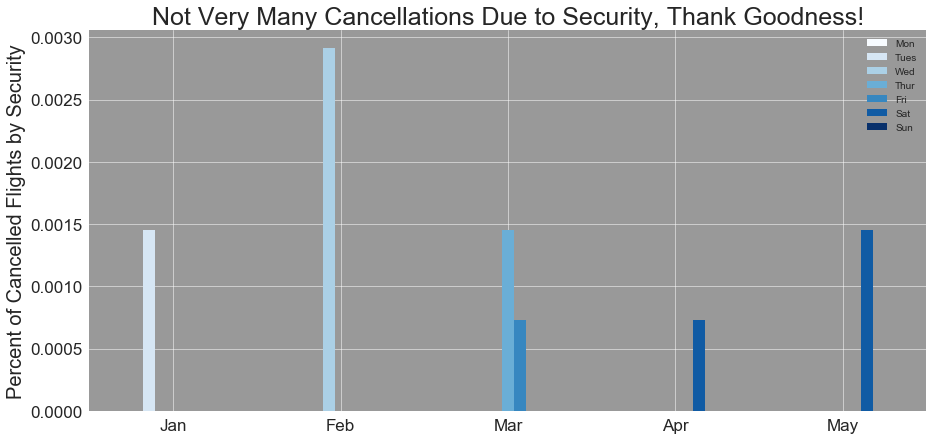

In [42]:
plotfunction(security, y_label='Percent of Cancelled Flights by Security', x_labels=m,
    title='Not Very Many Cancellations Due to Security, Thank Goodness!', simple=False); plt.show()

There is one very distinct trend seen in the graph above: there were very little cancellations due to security reasons.

<hr>
Let's now briefly look at which airlines are cancelling flights to see if there are any that stand out among the rest

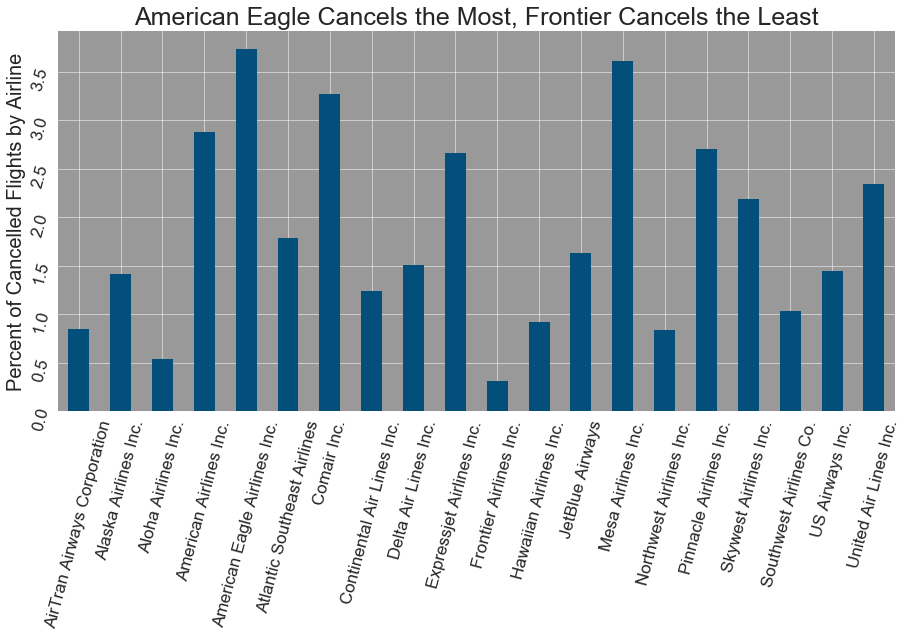

In [43]:
percent_cancelled_airline = df.Cancelled.groupby(df.Description).mean()*100
plotfunction(percent_cancelled_airline, y_label='Percent of Cancelled Flights by Airline',
             r=75, title='American Eagle Cancels the Most, Frontier Cancels the Least');plt.show()

We see Messa Airlines and American Eagle Airlines canceled more flights than other airlines in 2008, while Frontier Airlines canceled the least.

## Flight Delays

Of course, your flight being canceled can be extremely stressful and for some people could be the absolutely worst thing to happen to them when they need to be somewhere. However, its also useful to look at flight delays as well. A delay may be the lesser extreme of a cancellation, but it's nonetheless important to try to see trends in.

In [44]:
x = df[['ArrDelay', 'DepDelay', 'Description']]
arr = x[['ArrDelay', 'Description']]
arr['Delay'] = 'Arrival'
arr.columns = ['Time', 'Airline', 'Delay']

dep = x[['DepDelay', 'Description']]
dep['Delay'] = 'Departure'
dep.columns = ['Time', 'Airline', 'Delay']

violin = pd.concat([arr, dep], axis=0)

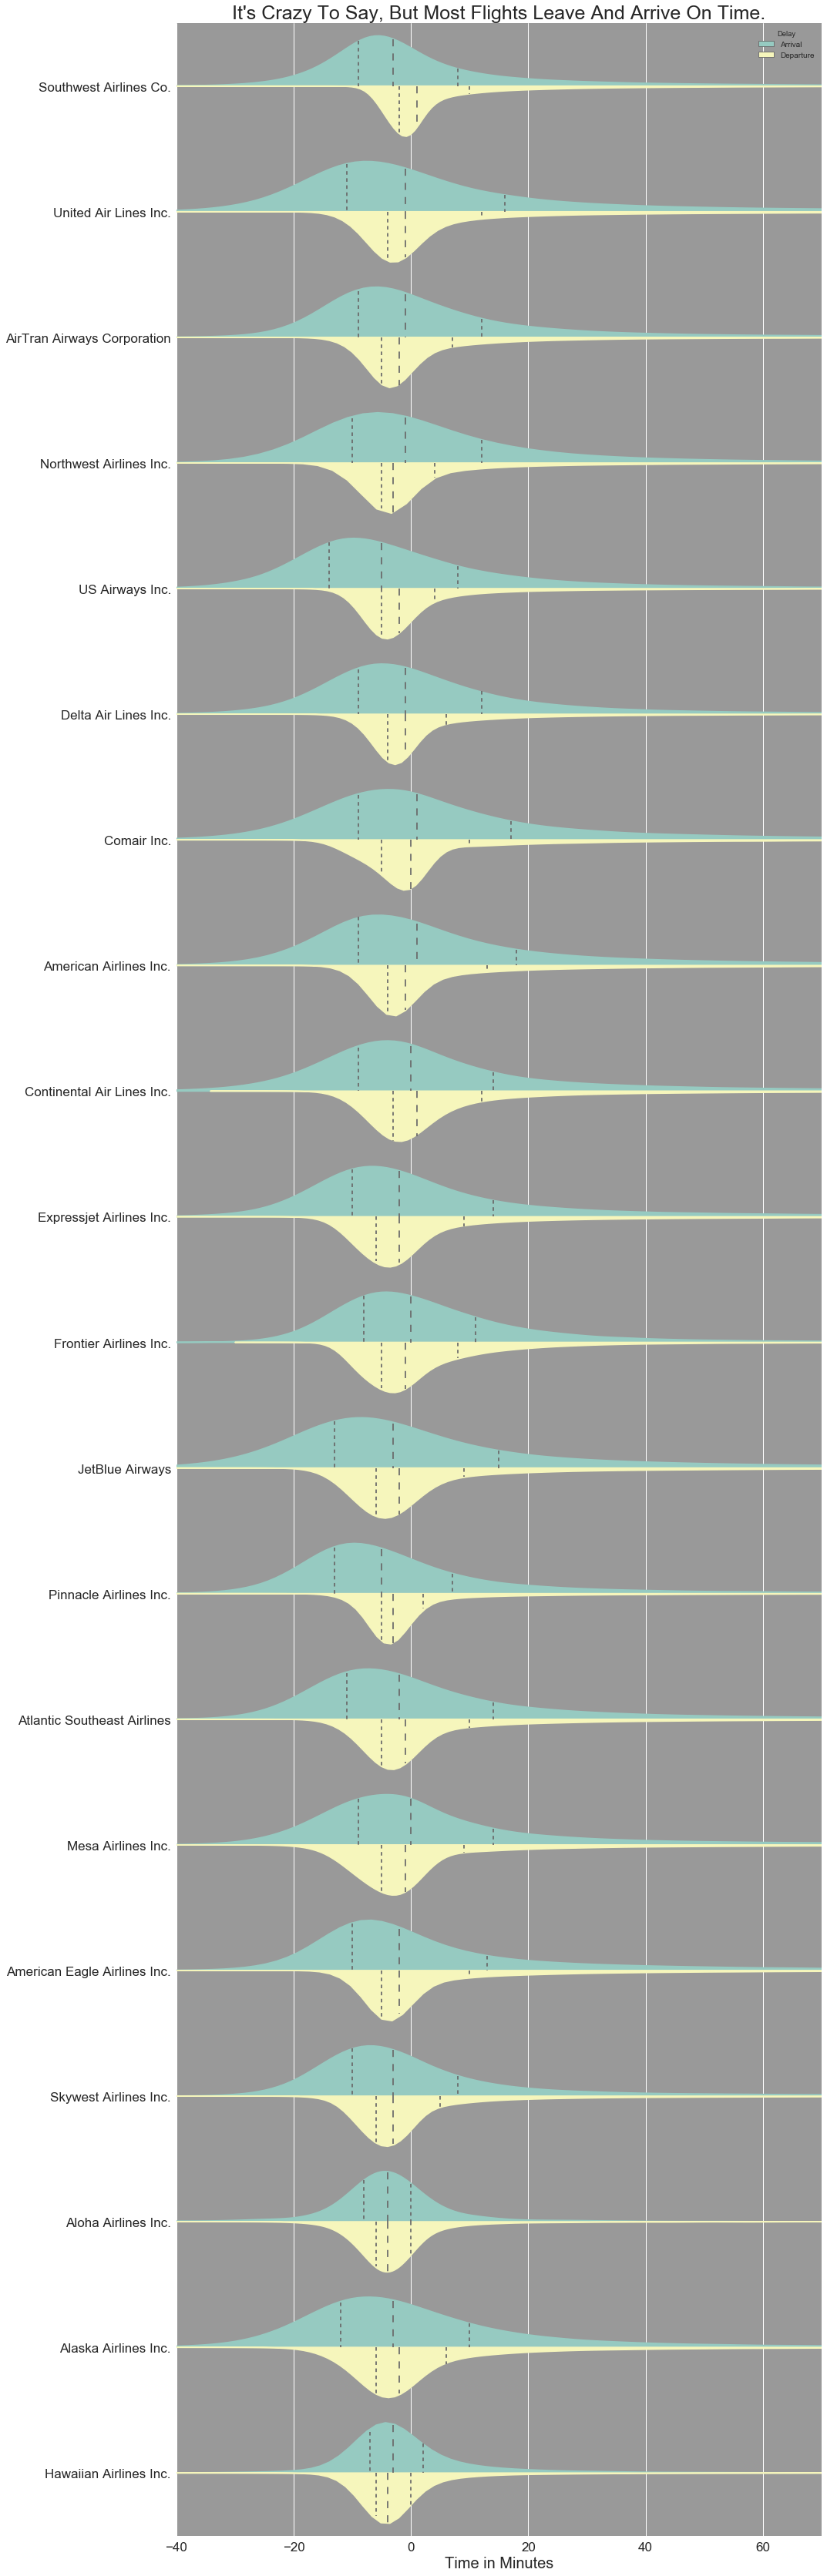

In [45]:
plt.figure(figsize=(15,60))
ax = sns.violinplot(x="Time", y="Airline", hue="Delay", data=violin, inner="quartile",
                    split=True, palette="Set3", gridsize=1000, scale='width')
ax.set_xlim(-40, 70)
ax.set_xlabel('Time in Minutes', fontsize=20)
ax.tick_params('both', labelsize=17)
ax.set_title("It's Crazy To Say, But Most Flights Leave And Arrive On Time.", fontsize=25)
ax.set_ylabel(''); plt.show()

This data shows that flight delays weren't a huge problem in 2008. Quite the contrary, a majority of flights were actually **early** (early arrival and departure are negative values). As the graph shows, a majority of flights were less than 20 minutes delayed, if at all. The graph also highlights that if a flight was delayed, it was more often delayed on arrival rather than departure. There is obvious correlation with these numbers, however, as a late arrival could lead to a late departure, consequently.

Let's break this down more and get a better idea of the data, numerically.

In [46]:
airline_delays = df[['ArrDelay', 'DepDelay']].groupby(df.Description)
mean = airline_delays.mean()
median = airline_delays.median()
airline_delays = pd.concat([mean, median], axis=1).round(decimals=1)
airline_delays.columns = ['mean_arival_delay', 'mean_depart_delay',
                          'median_arival_delay', 'median_depart_delay']

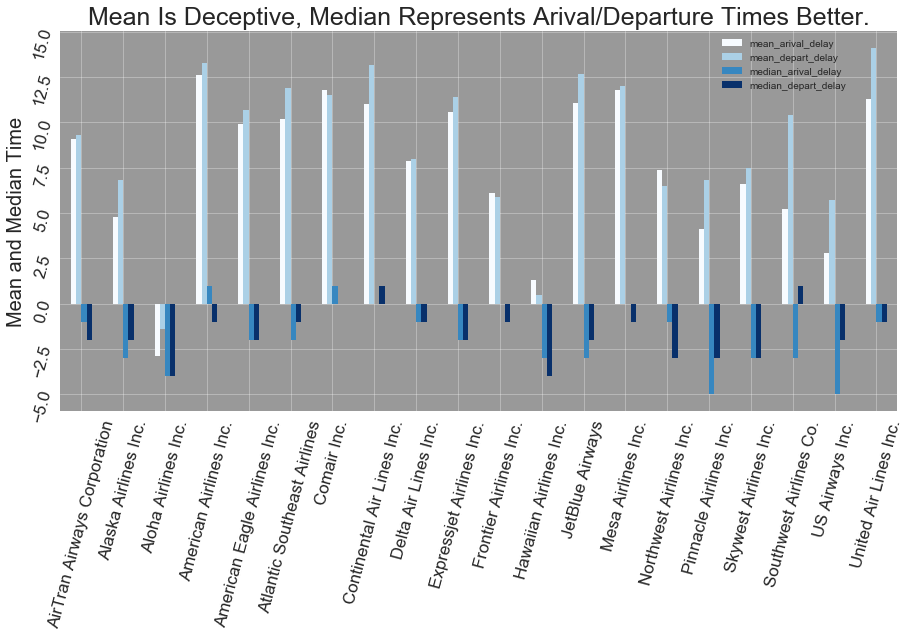

In [47]:
plotfunction(airline_delays, y_label='Mean and Median Time',r=75, simple=False, l=(0.95, 0.82),
    title='Mean Is Deceptive, Median Represents Arival/Departure Times Better.', a=.3); plt.show()

The chart above shows an important observation relating to the mean of the data. Contrary to what the violin plot showed, the means of most delay data is positive. From the violin plot, however, we can see that more of the data logged negative values. This likely means that there are larger positive values (e.g. late arrival/departure) that are throwing off the averages. That is why the median is shown to be more representative of the expectations set in the observations plotted beforehand.

Let's just consider the median values and see how delays worked monthly for these airlines.

In [48]:
airline_delays_m = df[['ArrDelay', 'DepDelay']].groupby([df.Description, df.Month])
median = airline_delays_m.median().unstack()
median_arr = median.loc[:,'ArrDelay']
median_dep = median.loc[:, 'DepDelay']
median_arr.columns, median_dep.columns = m, m

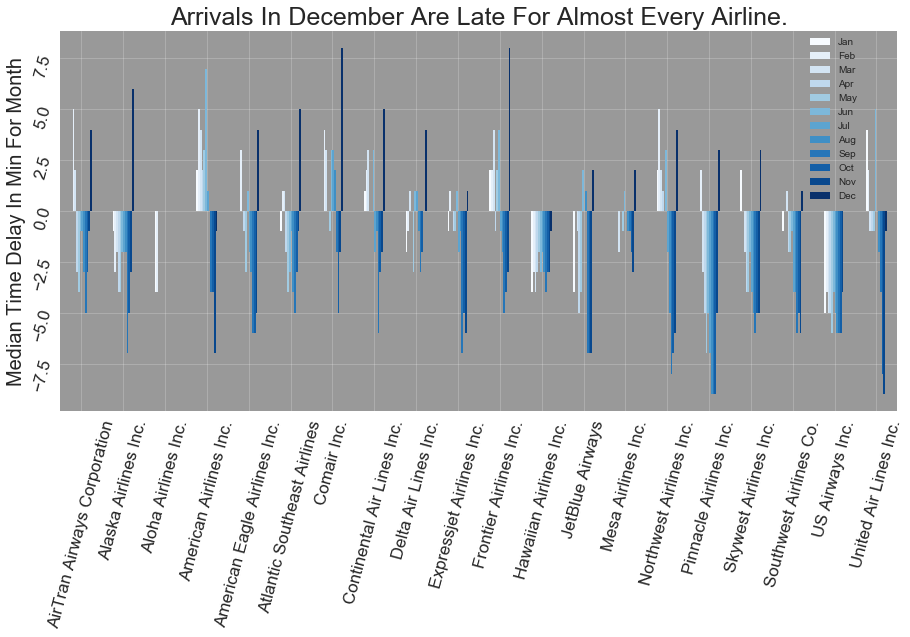

In [49]:
plotfunction(median_arr, y_label='Median Time Delay In Min For Month', r=75, l=(0.885, 0.53), a=.2,
        title='Arrivals In December Are Late For Almost Every Airline.', simple=False); plt.show()

There are a few things to note about the graph above. Firstly, it is evident that many flights in December were delayed upon arrival across most of the airlines. On the flip side, it appears that from April-November, most airlines saw earlier arrivals. There are also a few airlines that stick out among the rest. US Airways and Hawaiian Airlines can boast early arrival year round, while Aloha Airlines can say that either their flights will be on time, or they will be early! Can they say the same for departures, though?

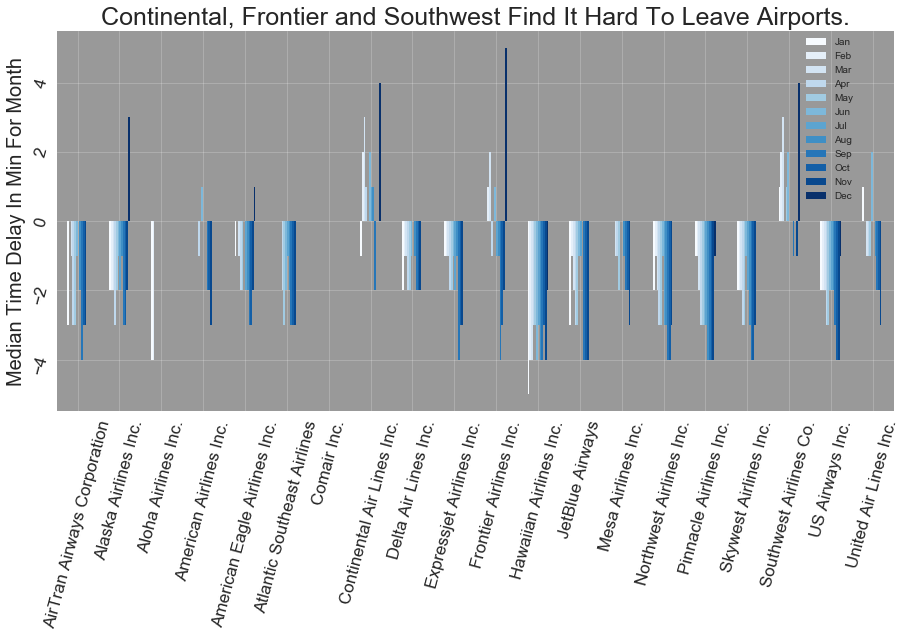

In [50]:
plotfunction(median_dep, y_label='Median Time Delay In Min For Month', r=75, l=(0.885, 0.53), a=.2,
        title='Continental, Frontier and Southwest Find It Hard To Leave Airports.',simple=False)
plt.show()

December still sees late departures, though at fewer airlines. Contrary to the arrivals, many of these airlines actually saw early departures year round, including the three airlines that could also say the same for their arrivals.

Lets look at the days of the week.

In [51]:
airline_delays_d = df[['ArrDelay', 'DepDelay']].groupby([df.Description, df.DayOfWeek])
median_d = airline_delays_d.median().unstack()
median_arr_d = median_d.loc[:,'ArrDelay']
median_dep_d = median_d.loc[:, 'DepDelay']
median_arr_d.columns, median_dep_d.columns = w, w

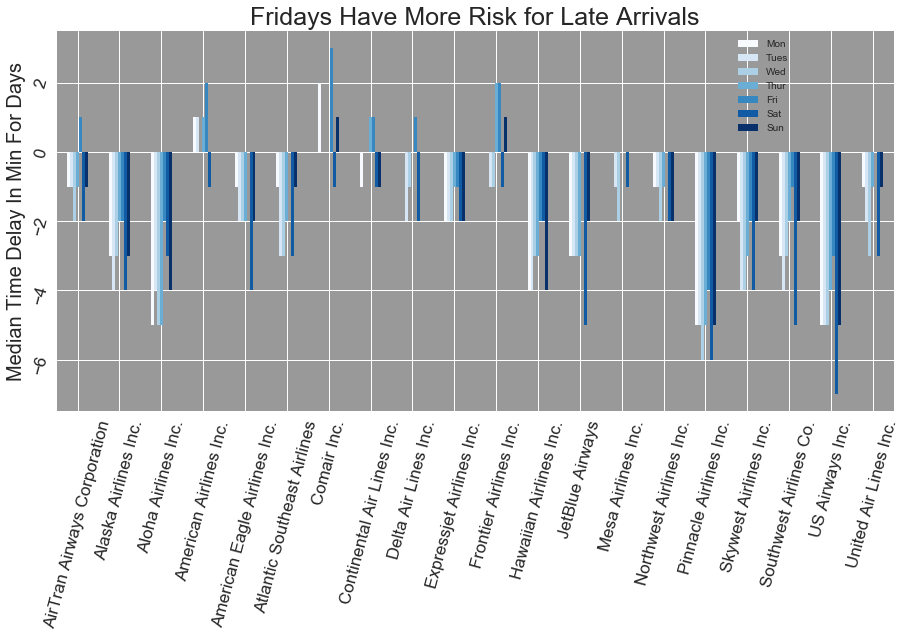

In [52]:
plotfunction(median_arr_d, y_label='Median Time Delay In Min For Days', r=75, l=(0.885, 1), a=1,
        title='Fridays Have More Risk for Late Arrivals', simple=False); plt.show()

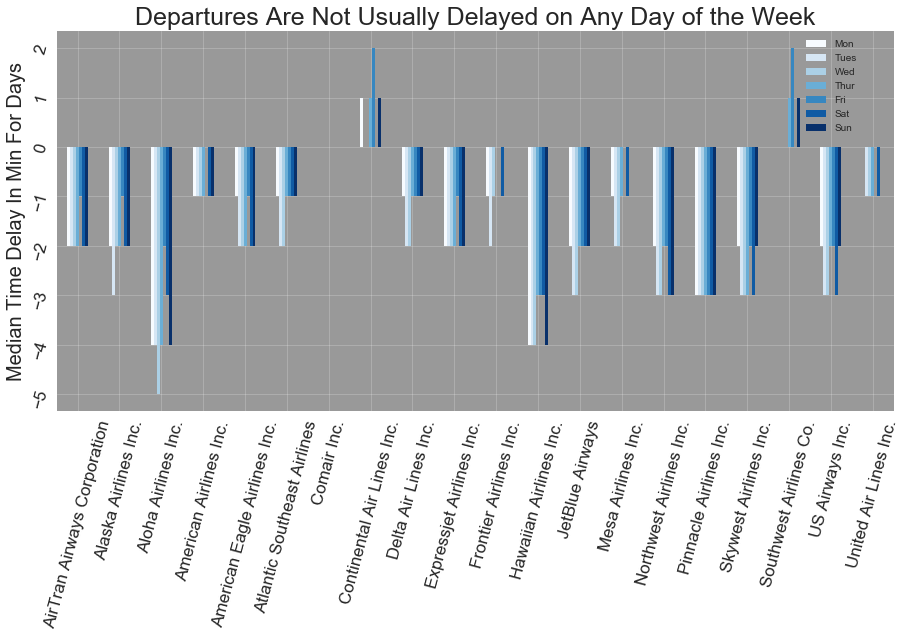

In [53]:
plotfunction(median_dep_d, y_label='Median Time Delay In Min For Days', r=75, l=(0.885, 1), a=.2,
        title='Departures Are Not Usually Delayed on Any Day of the Week',simple=False)
plt.show()

Both charts show that there aren't very extreme delays on any given day of the week, and instead shows the opposite. Most airlines actually primarily see early flights rather than late. Some standout airlines appear for the delayed departures, however. It would appear that Comair flights were usually not delayed, but were also usually not early either. Promptness in leaving an airport seems to be their strongsuit. On the other hand, Continental Air Lines and Southwest Airlines were the only ones to have median delay times show tardiness for 2008.

<hr>
Let's now see the median time delay for each different reason for delay to see which ones caused longer delays than others:

In [54]:
carrierDelay = (df["CarrierDelay"] > 0); carrierDelay_df = df[carrierDelay]
securityDelay = (df["SecurityDelay"] > 0); securityDelay_df = df[securityDelay]
weatherDelay = (df["WeatherDelay"] > 0); weatherDelay_df = df[weatherDelay]
latePlaneDelay = (df["LateAircraftDelay"] > 0); latePlaneDelay_df = df[latePlaneDelay]
NASDelay = (df["NASDelay"] > 0); NASDelay_df = df[NASDelay]

In [55]:
median_delay_carrier = carrierDelay_df["CarrierDelay"].groupby(df.Month).median()
median_delay_weather = weatherDelay_df["WeatherDelay"].groupby(df.Month).median()
median_delay_security = securityDelay_df["SecurityDelay"].groupby(df.Month).median()
median_delay_lateplane = latePlaneDelay_df["LateAircraftDelay"].groupby(df.Month).median()
median_delay_nas = NASDelay_df["NASDelay"].groupby(df.Month).median()

median_delay_all = pd.concat([median_delay_carrier,median_delay_weather,median_delay_security,
                              median_delay_lateplane,median_delay_nas], axis = 1)

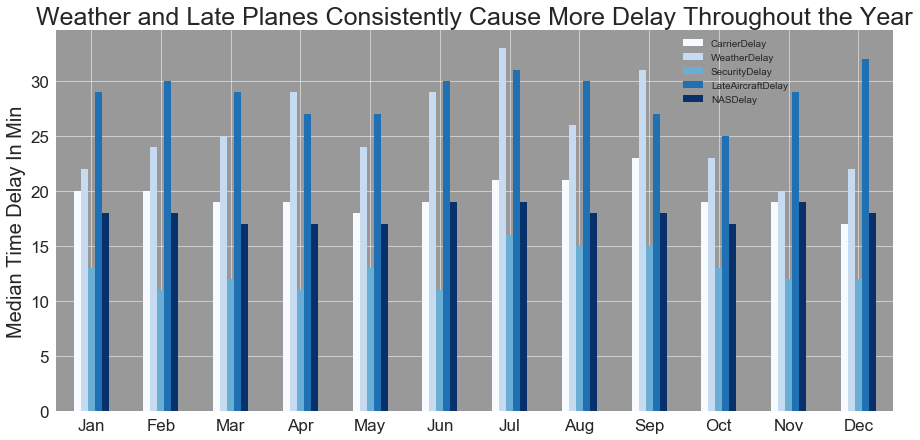

In [56]:
plotfunction(median_delay_all, y_label='Median Time Delay In Min', x_labels = m, l = (.885,1),
        title='Weather and Late Planes Consistently Cause More Delay Throughout the Year',
             simple = False)
plt.show()

As the graph shows, the least amount of delay is due to security reasons, while weather and late aircraft arrival are the leading causes every month.

Let's take a quick look at the delays geographically based on the airport.

## Geographic plot

In [57]:
d = df[['ArrDelay', 'DepDelay', 'origin_airport', 'origin_lat',
        'origin_long', 'dest_airport', 'dest_lat', 'dest_long']]
# causes of delays datafames
c_del = d[df.CarrierDelay > 0]
w_del = d[df.WeatherDelay > 0]
n_del = d[df.NASDelay > 0]
s_del = d[df.SecurityDelay > 0]
l_del = d[df.LateAircraftDelay > 0]

# departure delays
cd = c_del.groupby(c_del.origin_airport).median().drop(['ArrDelay',
                                                        'dest_lat', 'dest_long'], axis=1)
wd = w_del.groupby(w_del.origin_airport).median().drop(['ArrDelay',
                                                        'dest_lat', 'dest_long'], axis=1)
nd = n_del.groupby(n_del.origin_airport).median().drop(['ArrDelay',
                                                        'dest_lat', 'dest_long'], axis=1)
sd = s_del.groupby(s_del.origin_airport).median().drop(['ArrDelay',
                                                        'dest_lat', 'dest_long'], axis=1)
ld = l_del.groupby(l_del.origin_airport).median().drop(['ArrDelay',
                                                        'dest_lat', 'dest_long'], axis=1)
# arrival delays
ca = c_del.groupby(c_del.dest_airport).median().drop(['DepDelay',
                                                      'origin_lat', 'origin_long'], axis=1)
wa = w_del.groupby(w_del.dest_airport).median().drop(['DepDelay',
                                                      'origin_lat', 'origin_long'], axis=1)
na = n_del.groupby(n_del.dest_airport).median().drop(['DepDelay',
                                                      'origin_lat', 'origin_long'], axis=1)
sa = s_del.groupby(s_del.dest_airport).median().drop(['DepDelay',
                                                      'origin_lat', 'origin_long'], axis=1)
la = l_del.groupby(l_del.dest_airport).median().drop(['DepDelay',
                                                      'origin_lat', 'origin_long'], axis=1)

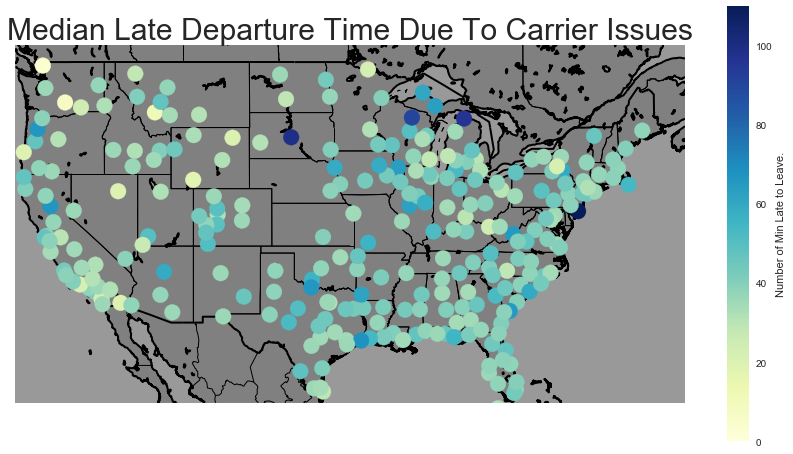

In [58]:
geo_graph(cd, 'Median Late Departure Time Due To Carrier Issues',
                                      'Number of Min Late to Leave.', (0, 110))

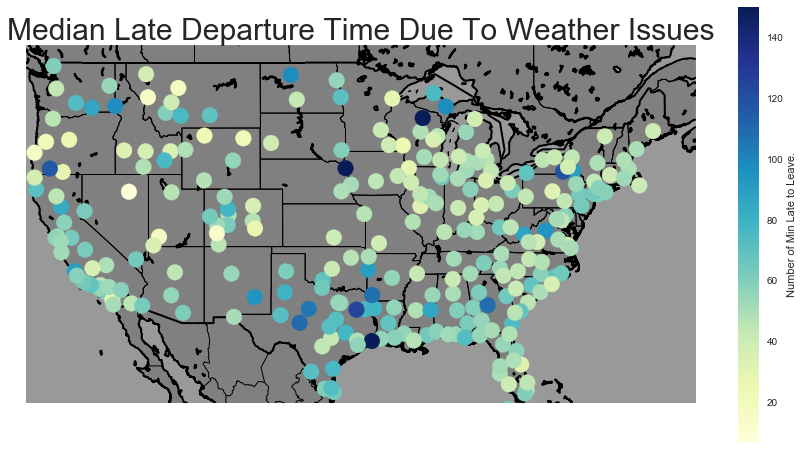

In [59]:
geo_graph(wd, 'Median Late Departure Time Due To Weather Issues',
                                      'Number of Min Late to Leave.', (7, 150))

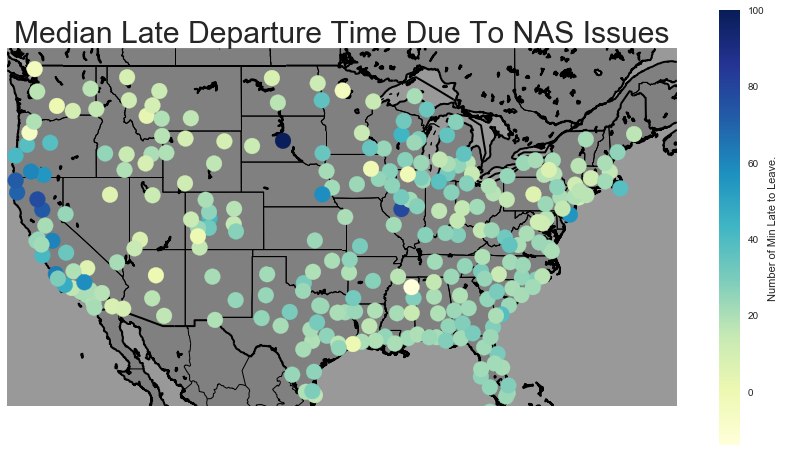

In [60]:
geo_graph(nd, 'Median Late Departure Time Due To NAS Issues',
                                      'Number of Min Late to Leave.', (-14, 100))

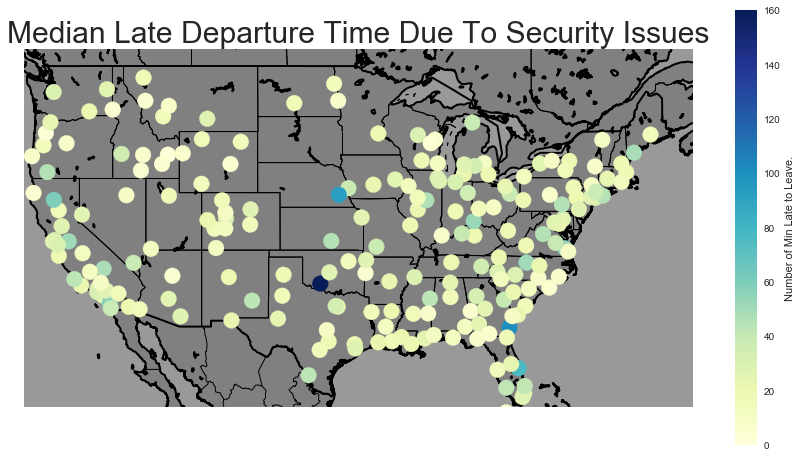

In [61]:
geo_graph(sd, 'Median Late Departure Time Due To Security Issues',
                                      'Number of Min Late to Leave.', (0, 160))

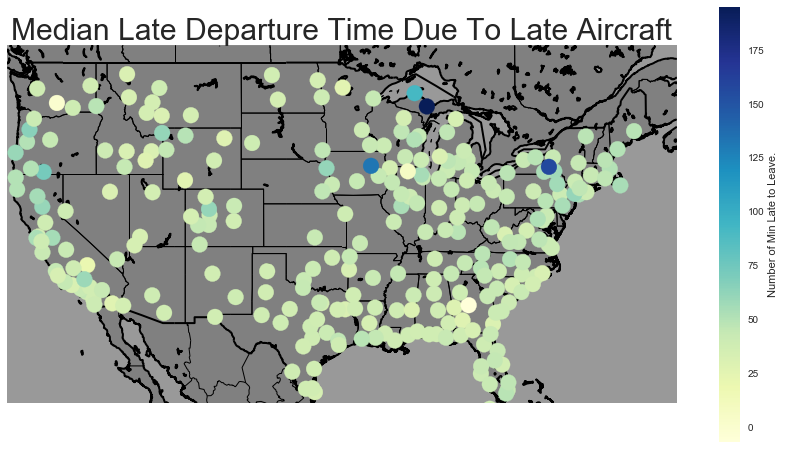

In [62]:
geo_graph(ld, 'Median Late Departure Time Due To Late Aircraft',
                                      'Number of Min Late to Leave.', (-7, 195))

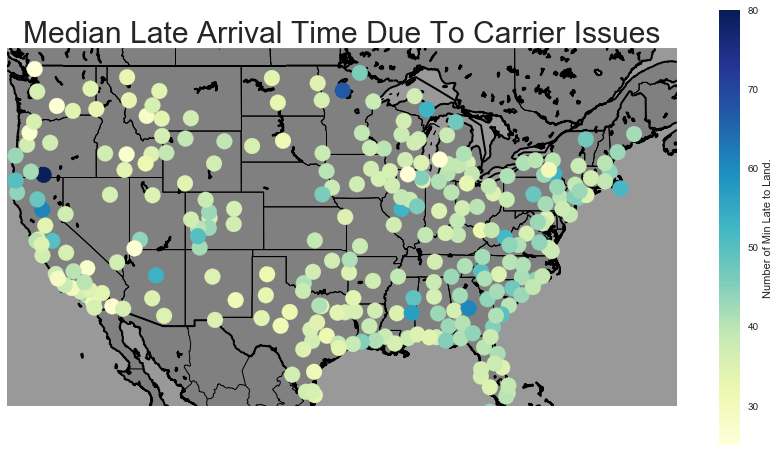

In [63]:
geo_graph(ca, 'Median Late Arrival Time Due To Carrier Issues',
                                      'Number of Min Late to Land.', (25, 80))

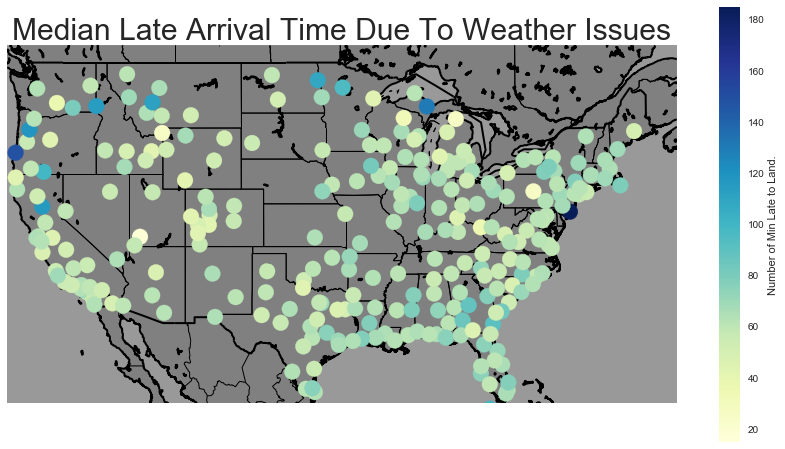

In [64]:
geo_graph(wa, 'Median Late Arrival Time Due To Weather Issues',
                                      'Number of Min Late to Land.', (15, 185))

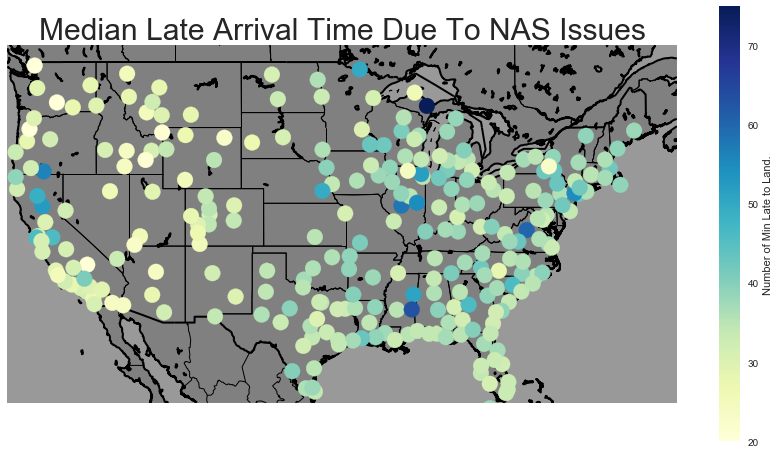

In [65]:
geo_graph(na, 'Median Late Arrival Time Due To NAS Issues',
                                      'Number of Min Late to Land.', (20, 75))

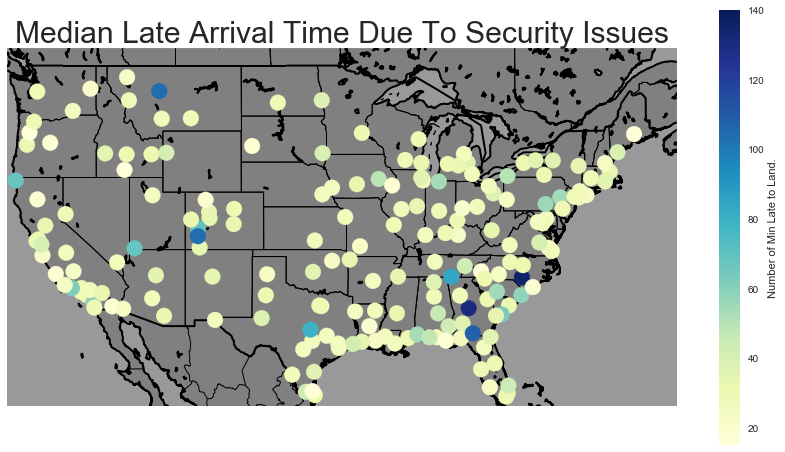

In [66]:
geo_graph(sa, 'Median Late Arrival Time Due To Security Issues',
                                      'Number of Min Late to Land.', (15, 140))

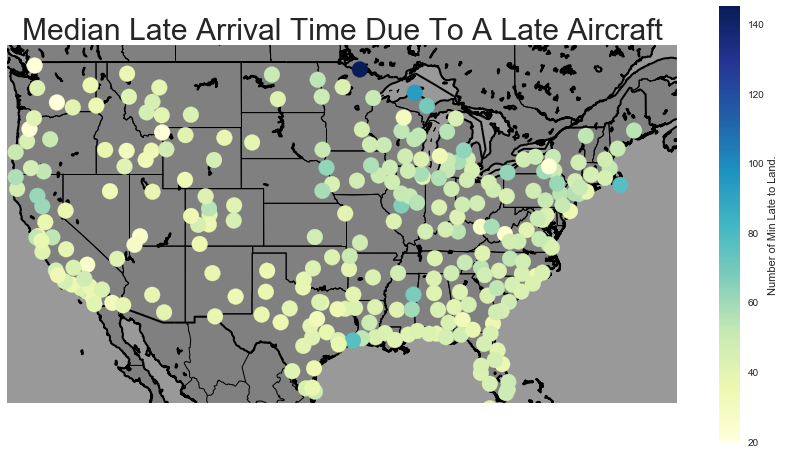

In [67]:
geo_graph(la, 'Median Late Arrival Time Due To A Late Aircraft',
                                      'Number of Min Late to Land.', (20, 145))

## Cancellations & Delays Summary
After Taking a Look at the Cancellations and Delays for the year of 2008, some things can be concluded.
<br/>
<br/>
### Cancellations
- 80% of cancelations are due to either weather or the airline.
- Cancellations are higher overall during the winter months, but surprisingly the month of September has a large amount of cancellations.
- There are very few cancellations due to security, thank god.
- The distribution of cancellations by individual airlines is a bit surprising, where airlines like Jetblue (an often joked about airline) has less cancellations than other more liked and known ones.
<br/>
<br/>

### Delays
- The most surprising thing is that most flights for all airlines not only are on time but are early; both on arrival and departure.
  - median is the best measure of the center of this data set because it is less affected by the outliers
- While the above is true, arrivals in December for most airlines are late, this makes sence of course because of the weather.
- Departures in December are mostly on time, although Southwest, Continental and Frontier seem to find it hard to leave.
<br/>
<br/>

## Logistic Regression

In [68]:
dummy_airlines = pd.get_dummies(df['Description'])

cols_to_keep = ['Cancelled']
Logitdata = df[cols_to_keep].join(dummy_airlines)
Logitdata['intercept'] = 1.0
Logitdata.head()

,Cancelled,AirTran Airways Corporation,Alaska Airlines Inc.,Aloha Airlines Inc.,American Airlines Inc.,American Eagle Airlines Inc.,Atlantic Southeast Airlines,Comair Inc.,Continental Air Lines Inc.,Delta Air Lines Inc.,...,Hawaiian Airlines Inc.,JetBlue Airways,Mesa Airlines Inc.,Northwest Airlines Inc.,Pinnacle Airlines Inc.,Skywest Airlines Inc.,Southwest Airlines Co.,US Airways Inc.,United Air Lines Inc.,intercept
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1.0


In [69]:
Logitdata.columns

Index(['Cancelled', 'AirTran Airways Corporation', 'Alaska Airlines Inc.',
       'Aloha Airlines Inc.', 'American Airlines Inc.',
       'American Eagle Airlines Inc.', 'Atlantic Southeast Airlines',
       'Comair Inc.', 'Continental Air Lines Inc.', 'Delta Air Lines Inc.',
       'Expressjet Airlines Inc.', 'Frontier Airlines Inc.',
       'Hawaiian Airlines Inc.', 'JetBlue Airways', 'Mesa Airlines Inc.',
       'Northwest Airlines Inc.', 'Pinnacle Airlines Inc.',
       'Skywest Airlines Inc.', 'Southwest Airlines Co.', 'US Airways Inc.',
       'United Air Lines Inc.', 'intercept'],
      dtype='object')


Let's make the columns shorter names for referencing purposes:

In [70]:
Logitdata.columns = ['Cancelled', 'AirTran', 'Alaska',
       'Aloha', 'American',
       'AmericanEagle', 'Atlantic',
       'Comair', 'Continental', 'Delta',
       'Expressjet', 'Frontier',
       'Hawaiian', 'JetBlue', 'Mesa',
       'Northwest', 'Pinnacle',
       'Skywest', 'Southwest', 'US',
       'United', 'intercept']

In [71]:
train_cols = Logitdata.columns[1:]
logit = sm.Logit(Logitdata['Cancelled'], Logitdata[train_cols])
result = logit.fit()

         Current function value: 0.094232
         Iterations: 35


In [72]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Cancelled   No. Observations:              7009728
Model:                          Logit   Df Residuals:                  7009708
Method:                           MLE   Df Model:                           19
Date:                Mon, 05 Feb 2018   Pseudo R-squ.:                 0.02353
Time:                        00:22:07   Log-Likelihood:            -6.6054e+05
converged:                      False   LL-Null:                   -6.7646e+05
                                        LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
AirTran          -0.7992   8560.719  -9.34e-05      1.000     -1.68e+04  1.68e+04
Alaska           -0.2887   8560.719  -3.37e-05      1.000     -1.68e+04  1.68e+04
Aloha            -1.2642   8560.719     -0.000      1.000     -1.68e+04  1.68e+04
American          0.4376   8560.719   5.11e-05      1.000     -1.68e+04  1.68e+04
AmericanEagle     0.7055   8560.719   8.24e-05      1.000     -1.68e+04  1.68e+04
Atlantic         -0.0495   8560.719  -5.78e-06      1.000     -1.68e+04  1.68e+04
Comair            0.5675   8560.719   6.63e-05      1.000     -1.68e+04  1.68e+04
Continental      -0.4226   8560.719  -4.94e-05      1.000     -1.68e+04  1.68e+04
Delta            -0.2249   8560.719  -2.63e-05      1.000     -1.68e+04  1.68e+04
Expressjet        0.3578   8560.719   4.18e-05      1.000     -1.68e+04  1.68e+04
Frontier         -1.7981   8560.719     -0.000      1.000     -1.68e+04  1.68e+04
Hawaiian         -0.7226   8560.719  -8.44e-05      1.000     -1.68e+04  1.68e+04
JetBlue          -0.1428   8560.719  -1.67e-05      1.000     -1.68e+04  1.68e+04
Mesa              0.6717   8560.719   7.85e-05      1.000     -1.68e+04  1.68e+04
Northwest        -0.8214   8560.719   -9.6e-05      1.000     -1.68e+04  1.68e+04
Pinnacle          0.3730   8560.719   4.36e-05      1.000     -1.68e+04  1.68e+04
Skywest           0.1567   8560.719   1.83e-05      1.000     -1.68e+04  1.68e+04
Southwest        -0.6097   8560.719  -7.12e-05      1.000     -1.68e+04  1.68e+04
US               -0.2636   8560.719  -3.08e-05      1.000     -1.68e+04  1.68e+04
United            0.2255   8560.719   2.63e-05      1.000     -1.68e+04  1.68e+04
intercept        -3.9546   8560.719     -0.000      1.000     -1.68e+04  1.68e+04
=================================================================================
"""

In [73]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

features = """AirTran+Alaska+Aloha+American+AmericanEagle+Atlantic+Comair+
              Continental+Delta+Expressjet+Frontier+Hawaiian+JetBlue+Mesa+Northwest+
              Pinnacle+Skywest+Southwest+US+United"""

# get y and X dataframes based on this regression:
y, X = dmatrices('Cancelled ~' + features, Logitdata, return_type='dataframe')
X.head()

,Intercept,AirTran,Alaska,Aloha,American,AmericanEagle,Atlantic,Comair,Continental,Delta,...,Frontier,Hawaiian,JetBlue,Mesa,Northwest,Pinnacle,Skywest,Southwest,US,United
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [74]:
#vif = pd.DataFrame()
#vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
#vif["features"] = X.columns

#Not able to calculate VIFs, but there is multicolinearity

The above code should calculate the Variance Inflation Factors for the regression model. However, the run time is so long that it will be left out in order to maintain reproducibility.

The initial goal of the exercise was to use logistic regression to create a tool that could predict whether or not a flight would be cancelled based on the airline; however, while the model did have an overall p-value of under 0.05 showing significance, none of the individual factors appear to be of any significant value to the model. This is a typical scenario when multicollinearity is present. It is interesting to see that although the individual factors are not significant, by analyzing the coefficients, we can determine which airlines have a higher risk of cancelling. For example, it was previously determined that American Eagle had the highest cancellation percentage and the coefficient for American Eagle is the highest at 0.7036. On the binary 0- not cancelled, 1- cancelled scale, having a coefficient closer to 1 means a higher chance of cancellation.